In [1]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

In [18]:
# dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Get unique user IDs

        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)

    else:
        print('Wrong data input')
        return None, None, None

    # Print the sizes of the datasets
    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Validation set size: {val.shape[0] if val is not None else 0} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    print(ml_full.shape[0])
    print(train.shape[0] + val.shape[0] +  test.shape[0])

    return train, val, test, n_users, n_items

def load_confounders(dat, k):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, val, test, n_users, n_items = choose_data(dat, test_size, val_size)

    if train is None or test is None:
        return None, None, None, None, None

    if include_validation:
        # Use the provided validation set
        vad = val
    else:
        # Merge train and validation sets if validation is not required, and sort by userId
        train = pd.concat([train, val]).sort_values(by='userId').reset_index(drop=True)
        vad = None

    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)
    vad_matrix = build_matrix(vad) if vad is not None else None

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, vad_matrix, n_users, n_items






random seed:  42


In [55]:
def run_model(module_name, class_name, k, dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)

    confounder_data = None
    exposure_data = None

    if use_confounder:
        # Load confounder data
        confounder_data = load_confounders(dat, k)
    if use_exposure:
        # Create exposure matrix
        exposure_data = (train > 0).astype(np.float32).todense().T
    
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        # Dynamically import the module and create an instance of the chosen class
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        # Determine how many arguments to pass to the execute function
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, test, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, test, confounder_data)
        else:
            final_model.execute(train, test)

        # Save the training and test RMSE values
        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'train_loss_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'test_rmse_{dat}_k{k}.npy')
            final_rmse_file = os.path.join(class_folder, f'final_rmse_{dat}_k{k}.npy')
            final_mae_file = os.path.join(class_folder, f'final_mae_{dat}_k{k}.npy')

            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))

            if confounder_data is not None and exposure_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data)
            else:
                final_rmse, final_mae = final_model.test(test)

            np.save(final_rmse_file, np.array(final_rmse))
            np.save(final_mae_file, np.array(final_mae))

        print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")


def run_all_models(result_path, models, k_values):
    for k in k_values:
        for model in models:
            use_confounder = 'conf' in model['module_name']
            use_exposure = 'exp' in model['module_name']
            
            print(f"Running {model['class_name']} with k={k}, use_confounder={use_confounder}, use_exposure={use_exposure}")
            run_model(model['module_name'], model['class_name'], k, dat='ml', include_validation=False, use_confounder=use_confounder, use_exposure=use_exposure, test_size=0.1, val_size=0.1, hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=80, batch_size=500, verbose=True, save_path=result_path)
            print(f"Completed {model['class_name']} with k={k}")


In [63]:
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    # {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [32, 100]

run_all_models(result_path, models, k_values)


Running UAutoRec1conf with k=100, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 80/80 [08:38<00:00,  6.48s/epoch, Loss=4.23e+4, RMSE=0.871, MAE=0.688]


Final RMSE: 0.8714670816791393, Final MAE: 0.6882190860401506
Completed UAutoRec1conf with k=100
Running UAutoRec1confexp with k=100, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.
Train data processed shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 80/80 [09:13<00:00,  6.91s/epoch, Loss=2.5e+4, RMSE=0.885, MAE=0.701] 


Final RMSE: 0.8850846907175748, Final MAE: 0.7013603500647162
Completed UAutoRec1confexp with k=100
Running UAutoRec2conf with k=100, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training: 100%|██████████| 80/80 [08:27<00:00,  6.34s/epoch, Loss=5.67e+4, RMSE=0.896, MAE=0.71] 


Final RMSE: 0.8959809479822212, Final MAE: 0.710241232566119
Completed UAutoRec2conf with k=100
Running UAutoRec2confexp with k=100, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 80/80 [08:40<00:00,  6.51s/epoch, Loss=5.4e+4, RMSE=0.882, MAE=0.697] 


Final RMSE: 0.8817742320017419, Final MAE: 0.696586097247225
Completed UAutoRec2confexp with k=100
Running UAutoRec3conf with k=100, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training:   0%|          | 0/80 [00:00<?, ?epoch/s]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   1%|▏         | 1/80 [00:04<06:24,  4.87s/epoch, Loss=4.01e+5, RMSE=1.42, MAE=1.13]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   2%|▎         | 2/80 [00:09<05:54,  4.54s/epoch, Loss=1.29e+5, RMSE=1.04, MAE=0.836]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   4%|▍         | 3/80 [00:13<05:46,  4.50s/epoch, Loss=8.63e+4, RMSE=1.01, MAE=0.826]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   5%|▌         | 4/80 [00:18<05:46,  4.56s/epoch, Loss=7.67e+4, RMSE=0.999, MAE=0.789]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   6%|▋         | 5/80 [00:22<05:35,  4.48s/epoch, Loss=7.42e+4, RMSE=0.989, MAE=0.797]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   8%|▊         | 6/80 [00:26<05:26,  4.41s/epoch, Loss=7.33e+4, RMSE=0.985, MAE=0.783]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:   9%|▉         | 7/80 [00:31<05:19,  4.37s/epoch, Loss=7.31e+4, RMSE=0.984, MAE=0.787]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  10%|█         | 8/80 [00:35<05:11,  4.33s/epoch, Loss=7.3e+4, RMSE=0.984, MAE=0.786] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  11%|█▏        | 9/80 [00:39<05:08,  4.34s/epoch, Loss=7.31e+4, RMSE=0.984, MAE=0.783]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  12%|█▎        | 10/80 [00:44<05:03,  4.33s/epoch, Loss=7.31e+4, RMSE=0.986, MAE=0.789]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  14%|█▍        | 11/80 [00:48<05:03,  4.39s/epoch, Loss=7.3e+4, RMSE=0.984, MAE=0.785] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  15%|█▌        | 12/80 [00:53<04:58,  4.40s/epoch, Loss=7.29e+4, RMSE=0.984, MAE=0.786]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  16%|█▋        | 13/80 [00:57<04:51,  4.35s/epoch, Loss=7.3e+4, RMSE=0.984, MAE=0.785] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  18%|█▊        | 14/80 [01:01<04:45,  4.33s/epoch, Loss=7.29e+4, RMSE=0.984, MAE=0.785]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  19%|█▉        | 15/80 [01:05<04:41,  4.33s/epoch, Loss=7.29e+4, RMSE=0.984, MAE=0.787]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  20%|██        | 16/80 [01:10<04:36,  4.32s/epoch, Loss=7.29e+4, RMSE=0.984, MAE=0.785]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  21%|██▏       | 17/80 [01:14<04:34,  4.36s/epoch, Loss=7.28e+4, RMSE=0.984, MAE=0.785]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  22%|██▎       | 18/80 [01:18<04:29,  4.35s/epoch, Loss=7.28e+4, RMSE=0.984, MAE=0.784]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  24%|██▍       | 19/80 [01:23<04:24,  4.33s/epoch, Loss=7.27e+4, RMSE=0.983, MAE=0.786]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  25%|██▌       | 20/80 [01:27<04:19,  4.32s/epoch, Loss=7.25e+4, RMSE=0.982, MAE=0.784]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  26%|██▋       | 21/80 [01:32<04:19,  4.40s/epoch, Loss=7.24e+4, RMSE=0.981, MAE=0.784]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  28%|██▊       | 22/80 [01:36<04:13,  4.38s/epoch, Loss=7.22e+4, RMSE=0.979, MAE=0.782]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  29%|██▉       | 23/80 [01:40<04:10,  4.39s/epoch, Loss=7.2e+4, RMSE=0.98, MAE=0.781]  

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  30%|███       | 24/80 [01:45<04:04,  4.37s/epoch, Loss=7.18e+4, RMSE=0.977, MAE=0.779]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  31%|███▏      | 25/80 [01:49<03:59,  4.35s/epoch, Loss=7.15e+4, RMSE=0.976, MAE=0.777]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  32%|███▎      | 26/80 [01:53<03:54,  4.34s/epoch, Loss=7.13e+4, RMSE=0.974, MAE=0.777]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  34%|███▍      | 27/80 [01:58<03:49,  4.33s/epoch, Loss=7.1e+4, RMSE=0.971, MAE=0.774] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  35%|███▌      | 28/80 [02:02<03:45,  4.33s/epoch, Loss=7.07e+4, RMSE=0.971, MAE=0.775]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  36%|███▋      | 29/80 [02:06<03:40,  4.32s/epoch, Loss=7.04e+4, RMSE=0.969, MAE=0.773]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  38%|███▊      | 30/80 [02:11<03:36,  4.34s/epoch, Loss=7.03e+4, RMSE=0.969, MAE=0.771]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  39%|███▉      | 31/80 [02:15<03:31,  4.32s/epoch, Loss=6.99e+4, RMSE=0.964, MAE=0.769]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  40%|████      | 32/80 [02:19<03:27,  4.32s/epoch, Loss=6.95e+4, RMSE=0.964, MAE=0.767]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  41%|████▏     | 33/80 [02:24<03:22,  4.31s/epoch, Loss=6.92e+4, RMSE=0.962, MAE=0.766]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  42%|████▎     | 34/80 [02:28<03:17,  4.30s/epoch, Loss=6.9e+4, RMSE=0.96, MAE=0.767]  

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  44%|████▍     | 35/80 [02:32<03:14,  4.31s/epoch, Loss=6.87e+4, RMSE=0.958, MAE=0.764]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  45%|████▌     | 36/80 [02:36<03:09,  4.30s/epoch, Loss=6.85e+4, RMSE=0.958, MAE=0.762]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  46%|████▋     | 37/80 [02:41<03:06,  4.33s/epoch, Loss=6.81e+4, RMSE=0.957, MAE=0.764]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  48%|████▊     | 38/80 [02:45<03:01,  4.31s/epoch, Loss=6.8e+4, RMSE=0.953, MAE=0.759] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  49%|████▉     | 39/80 [02:50<03:02,  4.45s/epoch, Loss=6.76e+4, RMSE=0.952, MAE=0.757]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  50%|█████     | 40/80 [02:56<03:24,  5.10s/epoch, Loss=6.74e+4, RMSE=0.951, MAE=0.756]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  51%|█████▏    | 41/80 [03:03<03:34,  5.49s/epoch, Loss=6.72e+4, RMSE=0.951, MAE=0.759]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  52%|█████▎    | 42/80 [03:09<03:34,  5.64s/epoch, Loss=6.69e+4, RMSE=0.948, MAE=0.755]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  54%|█████▍    | 43/80 [03:15<03:30,  5.69s/epoch, Loss=6.67e+4, RMSE=0.948, MAE=0.755]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  55%|█████▌    | 44/80 [03:20<03:26,  5.73s/epoch, Loss=6.64e+4, RMSE=0.946, MAE=0.753]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  56%|█████▋    | 45/80 [03:27<03:27,  5.94s/epoch, Loss=6.62e+4, RMSE=0.943, MAE=0.751]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  57%|█████▊    | 46/80 [03:33<03:21,  5.92s/epoch, Loss=6.59e+4, RMSE=0.942, MAE=0.75] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  59%|█████▉    | 47/80 [03:39<03:15,  5.92s/epoch, Loss=6.56e+4, RMSE=0.942, MAE=0.752]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  60%|██████    | 48/80 [03:45<03:09,  5.91s/epoch, Loss=6.55e+4, RMSE=0.941, MAE=0.749]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  61%|██████▏   | 49/80 [03:50<03:01,  5.86s/epoch, Loss=6.53e+4, RMSE=0.939, MAE=0.747]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  62%|██████▎   | 50/80 [03:56<02:57,  5.93s/epoch, Loss=6.49e+4, RMSE=0.938, MAE=0.745]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  64%|██████▍   | 51/80 [04:03<02:54,  6.02s/epoch, Loss=6.48e+4, RMSE=0.935, MAE=0.744]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  65%|██████▌   | 52/80 [04:08<02:44,  5.88s/epoch, Loss=6.44e+4, RMSE=0.934, MAE=0.744]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  66%|██████▋   | 53/80 [04:14<02:36,  5.81s/epoch, Loss=6.41e+4, RMSE=0.932, MAE=0.74] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  68%|██████▊   | 54/80 [04:20<02:30,  5.80s/epoch, Loss=6.39e+4, RMSE=0.932, MAE=0.742]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  69%|██████▉   | 55/80 [04:25<02:24,  5.77s/epoch, Loss=6.36e+4, RMSE=0.93, MAE=0.739] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  70%|███████   | 56/80 [04:31<02:18,  5.77s/epoch, Loss=6.34e+4, RMSE=0.928, MAE=0.737]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  71%|███████▏  | 57/80 [04:37<02:14,  5.87s/epoch, Loss=6.31e+4, RMSE=0.927, MAE=0.738]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  72%|███████▎  | 58/80 [04:43<02:07,  5.81s/epoch, Loss=6.28e+4, RMSE=0.927, MAE=0.739]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  74%|███████▍  | 59/80 [04:49<02:02,  5.84s/epoch, Loss=6.25e+4, RMSE=0.924, MAE=0.736]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  75%|███████▌  | 60/80 [04:55<01:56,  5.81s/epoch, Loss=6.22e+4, RMSE=0.923, MAE=0.733]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  76%|███████▋  | 61/80 [05:00<01:49,  5.75s/epoch, Loss=6.2e+4, RMSE=0.921, MAE=0.732] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  78%|███████▊  | 62/80 [05:06<01:45,  5.85s/epoch, Loss=6.17e+4, RMSE=0.92, MAE=0.732]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  79%|███████▉  | 63/80 [05:13<01:42,  6.01s/epoch, Loss=6.15e+4, RMSE=0.919, MAE=0.729]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  80%|████████  | 64/80 [05:18<01:34,  5.94s/epoch, Loss=6.11e+4, RMSE=0.916, MAE=0.727]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  81%|████████▏ | 65/80 [05:24<01:27,  5.86s/epoch, Loss=6.08e+4, RMSE=0.915, MAE=0.728]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  82%|████████▎ | 66/80 [05:30<01:22,  5.89s/epoch, Loss=6.06e+4, RMSE=0.914, MAE=0.726]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  84%|████████▍ | 67/80 [05:36<01:15,  5.84s/epoch, Loss=6.03e+4, RMSE=0.913, MAE=0.725]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  85%|████████▌ | 68/80 [05:42<01:09,  5.82s/epoch, Loss=6e+4, RMSE=0.909, MAE=0.722]   

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  86%|████████▋ | 69/80 [05:48<01:04,  5.88s/epoch, Loss=5.96e+4, RMSE=0.908, MAE=0.722]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  88%|████████▊ | 70/80 [05:53<00:58,  5.83s/epoch, Loss=5.94e+4, RMSE=0.909, MAE=0.721]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  89%|████████▉ | 71/80 [05:59<00:52,  5.78s/epoch, Loss=5.92e+4, RMSE=0.907, MAE=0.72] 

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  90%|█████████ | 72/80 [06:05<00:47,  5.96s/epoch, Loss=5.9e+4, RMSE=0.904, MAE=0.717]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  91%|█████████▏| 73/80 [06:12<00:42,  6.07s/epoch, Loss=5.86e+4, RMSE=0.903, MAE=0.718]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  92%|█████████▎| 74/80 [06:17<00:35,  6.00s/epoch, Loss=5.83e+4, RMSE=0.902, MAE=0.715]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  94%|█████████▍| 75/80 [06:23<00:29,  5.93s/epoch, Loss=5.81e+4, RMSE=0.901, MAE=0.715]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  95%|█████████▌| 76/80 [06:29<00:23,  5.94s/epoch, Loss=5.78e+4, RMSE=0.902, MAE=0.715]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  96%|█████████▋| 77/80 [06:35<00:17,  5.93s/epoch, Loss=5.75e+4, RMSE=0.898, MAE=0.712]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  98%|█████████▊| 78/80 [06:41<00:11,  5.89s/epoch, Loss=5.73e+4, RMSE=0.898, MAE=0.712]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training:  99%|█████████▉| 79/80 [06:47<00:05,  5.91s/epoch, Loss=5.71e+4, RMSE=0.897, MAE=0.711]

Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)
Train data shape: (3706, 6040)
Confounder data shape: (3706, 6040)


Training: 100%|██████████| 80/80 [06:52<00:00,  5.16s/epoch, Loss=5.68e+4, RMSE=0.896, MAE=0.711]


Final RMSE: 0.8963843228736388, Final MAE: 0.710955229494917
Completed UAutoRec3conf with k=100
Running UAutoRec3confexp with k=100, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 80/80 [08:19<00:00,  6.25s/epoch, Loss=5.68e+4, RMSE=0.895, MAE=0.709]


Final RMSE: 0.8949812720954456, Final MAE: 0.7088107601509808
Completed UAutoRec3confexp with k=100
Running UAutoRec4conf with k=100, use_confounder=True, use_exposure=False
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder.


Training: 100%|██████████| 80/80 [10:41<00:00,  8.02s/epoch, Loss=4.49e+4, RMSE=0.928, MAE=0.726]


Final RMSE: 0.9282131175284825, Final MAE: 0.7257081274134188
Completed UAutoRec4conf with k=100
Running UAutoRec4confexp with k=100, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Validation set size: 100022 ratings
Test set size: 100022 ratings
1000213
1000213
Load data finished. Number of users: 6040 Number of items: 3706
UAutoRec with Confounder and Exposure.


Training: 100%|██████████| 80/80 [17:03<00:00, 12.79s/epoch, Loss=6.32e+3, RMSE=1.05, MAE=0.826] 


Final RMSE: 1.0460559653567805, Final MAE: 0.8263600712880054
Completed UAutoRec4confexp with k=100


uautorec (k=32) - Train loss history shape: (80,)
uautorec (k=32) - Test RMSE history shape: (80,)
uautorec1conf (k=32) - Train loss history shape: (80,)
uautorec1conf (k=32) - Test RMSE history shape: (80,)
uautorec1confexp (k=32) - Train loss history shape: (80,)
uautorec1confexp (k=32) - Test RMSE history shape: (80,)
uautorec2confexp (k=32) - Train loss history shape: (80,)
uautorec2confexp (k=32) - Test RMSE history shape: (80,)
uautorec4conf (k=32) - Train loss history shape: (80,)
uautorec4conf (k=32) - Test RMSE history shape: (80,)
uautorec4confexp (k=32) - Train loss history shape: (80,)
uautorec4confexp (k=32) - Test RMSE history shape: (80,)


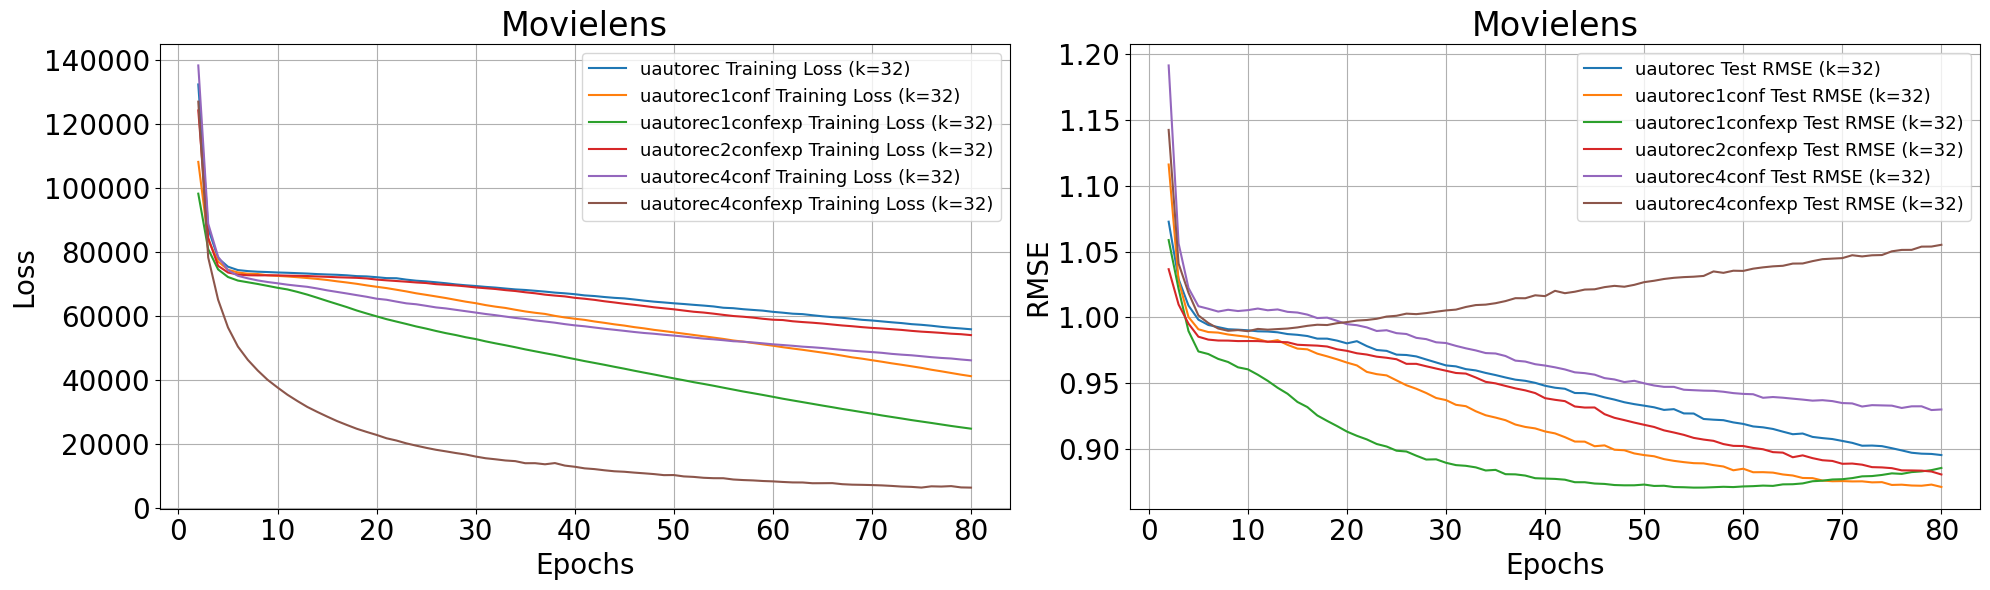

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_results(result_path, models, k_values):
    plt.figure(figsize=(20, 6))

    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            train_loss_file = os.path.join(class_folder, f'train_loss_ml_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'test_rmse_ml_k{k}.npy')

            if not os.path.exists(train_loss_file) or not os.path.exists(test_rmse_file):
                print(f"Files for {class_name} with k={k} not found.")
                continue

            train_loss_history = np.load(train_loss_file)
            test_rmse_history = np.load(test_rmse_file)

            print(f"{class_name} (k={k}) - Train loss history shape: {train_loss_history.shape}")
            print(f"{class_name} (k={k}) - Test RMSE history shape: {test_rmse_history.shape}")

            epochs = np.arange(1, len(train_loss_history) + 1)

            # Plot training loss
            plt.subplot(1, 2, 1)
            plt.plot(epochs[1:], train_loss_history[1:], label=f'{class_name} Training Loss (k={k})')
            
            # Plot test RMSE
            plt.subplot(1, 2, 2)
            plt.plot(epochs[1:], test_rmse_history[1:], label=f'{class_name} Test RMSE (k={k})')


    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize = 24)
    plt.legend(fontsize = 13)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('RMSE', fontsize = 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize = 24)
    plt.legend(fontsize = 13)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1Conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1ConfExp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2Conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2ConfExp'},
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3Conf'},
    # {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3ConfExp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4Conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4ConfExp'}
]
k_values = [32]  # Add all the k values you want to plot

plot_results(result_path, models, k_values)

In [65]:
import os
import numpy as np
import pandas as pd

def load_rmse_history(result_path, models, k_values):
    results = []

    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            test_rmse_file = os.path.join(class_folder, f'test_rmse_ml_k{k}.npy')

            if not os.path.exists(test_rmse_file):
                print(f"Test RMSE file for {class_name} with k={k} not found.")
                continue

            test_rmse_history = np.load(test_rmse_file)
            final_rmse = test_rmse_history[-1]  # Last RMSE value
            best_rmse = np.min(test_rmse_history)  # Lowest RMSE value

            results.append({
                'Model': model['class_name'],
                'k': k,
                'Final RMSE': final_rmse,
                'Best RMSE': best_rmse
            })

    return pd.DataFrame(results)

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [32, 100]

results_df = load_rmse_history(result_path, models, k_values)
print(results_df)

# Save the results to a CSV file if needed
results_csv_file = os.path.join(result_path, 'rmse_results.csv')
results_df.to_csv(results_csv_file, index=False)


Test RMSE file for uautorec with k=100 not found.
               Model    k  Final RMSE  Best RMSE
0           UAutoRec   32    0.895188   0.895188
1      UAutoRec1conf   32    0.870916   0.870916
2   UAutoRec1confexp   32    0.885382   0.870422
3      UAutoRec2conf   32    0.897396   0.897396
4   UAutoRec2confexp   32    0.880419   0.880419
5      UAutoRec3conf   32    0.897542   0.897466
6   UAutoRec3confexp   32    0.893128   0.893128
7      UAutoRec4conf   32    0.929876   0.929436
8   UAutoRec4confexp   32    1.055153   0.989415
9      UAutoRec1conf  100    0.871467   0.871467
10  UAutoRec1confexp  100    0.885085   0.870266
11     UAutoRec2conf  100    0.895981   0.895981
12  UAutoRec2confexp  100    0.881774   0.881774
13     UAutoRec3conf  100    0.896384   0.896384
14  UAutoRec3confexp  100    0.894981   0.894981
15     UAutoRec4conf  100    0.928213   0.928213
16  UAutoRec4confexp  100    1.046056   0.986982


Test RMSE file for uautorec with k=100 not found.
               Model    k          Final RMSE  Best RMSE
0           UAutoRec   32  0.8951881399552926   0.895188
1      UAutoRec1conf   32  0.8709157246374017   0.870916
2   UAutoRec1confexp   32  0.8853822227308931   0.870422
3      UAutoRec2conf   32  0.8973961016530623   0.897396
4   UAutoRec2confexp   32  0.8804192385313928   0.880419
5      UAutoRec3conf   32  0.8975423166217638   0.897466
6   UAutoRec3confexp   32  0.8931277080242566   0.893128
7      UAutoRec4conf   32  0.9298756286976327   0.929436
8   UAutoRec4confexp   32  1.0551527760104047   0.989415
9      UAutoRec1conf  100  0.8714670816791393   0.871467
10  UAutoRec1confexp  100  0.8850846907175748   0.870266
11     UAutoRec2conf  100  0.8959809479822212   0.895981
12  UAutoRec2confexp  100  0.8817742320017419   0.881774
13     UAutoRec3conf  100  0.8963843228736388   0.896384
14  UAutoRec3confexp  100  0.8949812720954456   0.894981
15     UAutoRec4conf  100  0.928213117